In [0]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

In [78]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
input_file = codecs.open("/content/drive/My Drive/Colab Notebooks/socialmedia_relevant_cols.csv", "r",encoding='utf-8', errors='replace')
output_file = open("socialmedia_relevant_cols_clean.csv", "w")

def sanitize_characters(raw, clean):    
    for line in input_file:
        out = line
        output_file.write(line)
sanitize_characters(input_file, output_file)

In [81]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
questions = pd.read_csv("socialmedia_relevant_cols_clean.csv", index_col=None)
questions.columns=['text', 'choose_one', 'class_label']
questions.head()

text choose_one  class_label
0                 Just happened a terrible car crash   Relevant            1
1  Our Deeds are the Reason of this #earthquake M...   Relevant            1
2  Heard about #earthquake is different cities, s...   Relevant            1
3  there is a forest fire at spot pond, geese are...   Relevant            1
4             Forest fire near La Ronge Sask. Canada   Relevant            1

In [83]:
questions.tail()

text  ... class_label
10854  1.3 #Earthquake in 9Km Ssw Of Anza California ...  ...           1
10855  Evacuation order lifted for town of Roosevelt:...  ...           1
10856  See the 16yr old PKK suicide bomber who detona...  ...           1
10857  To conference attendees! The blue line from th...  ...           1
10858  The death toll in a #IS-suicide car bombing on...  ...           1

[5 rows x 3 columns]

In [84]:
questions.describe()

class_label
count  10859.000000
mean       0.431808
std        0.498317
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        2.000000

In [85]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "text")

questions.to_csv("clean_data.csv")
questions.head()

text choose_one  class_label
0                 just happened a terrible car crash   Relevant            1
1  our deeds are the reason of this  earthquake m...   Relevant            1
2  heard about  earthquake is different cities, s...   Relevant            1
3  there is a forest fire at spot pond, geese are...   Relevant            1
4             forest fire near la ronge sask  canada   Relevant            1

In [86]:
clean_questions = pd.read_csv("clean_data.csv")
clean_questions.tail()

Unnamed: 0  ... class_label
10854       10854  ...           1
10855       10855  ...           1
10856       10856  ...           1
10857       10857  ...           1
10858       10858  ...           1

[5 rows x 4 columns]

In [87]:
clean_questions.groupby("class_label").count()

Unnamed: 0  text  choose_one
class_label                              
0                  6186  6186        6186
1                  4657  4657        4657
2                    16    16          16

In [88]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

Unnamed: 0  ...                                             tokens
0           0  ...          [just, happened, a, terrible, car, crash]
1           1  ...  [our, deeds, are, the, reason, of, this, earth...
2           2  ...  [heard, about, earthquake, is, different, citi...
3           3  ...  [there, is, a, forest, fire, at, spot, pond, g...
4           4  ...      [forest, fire, near, la, ronge, sask, canada]

[5 rows x 5 columns]

In [89]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

154484 words total, with a vocabulary size of 18095
Max sentence length is 34


In [0]:
import matplotlib.pyplot as plt

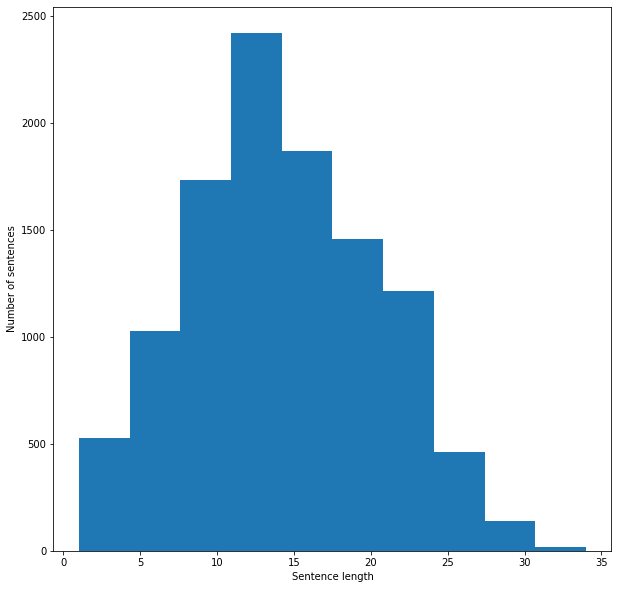

In [91]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

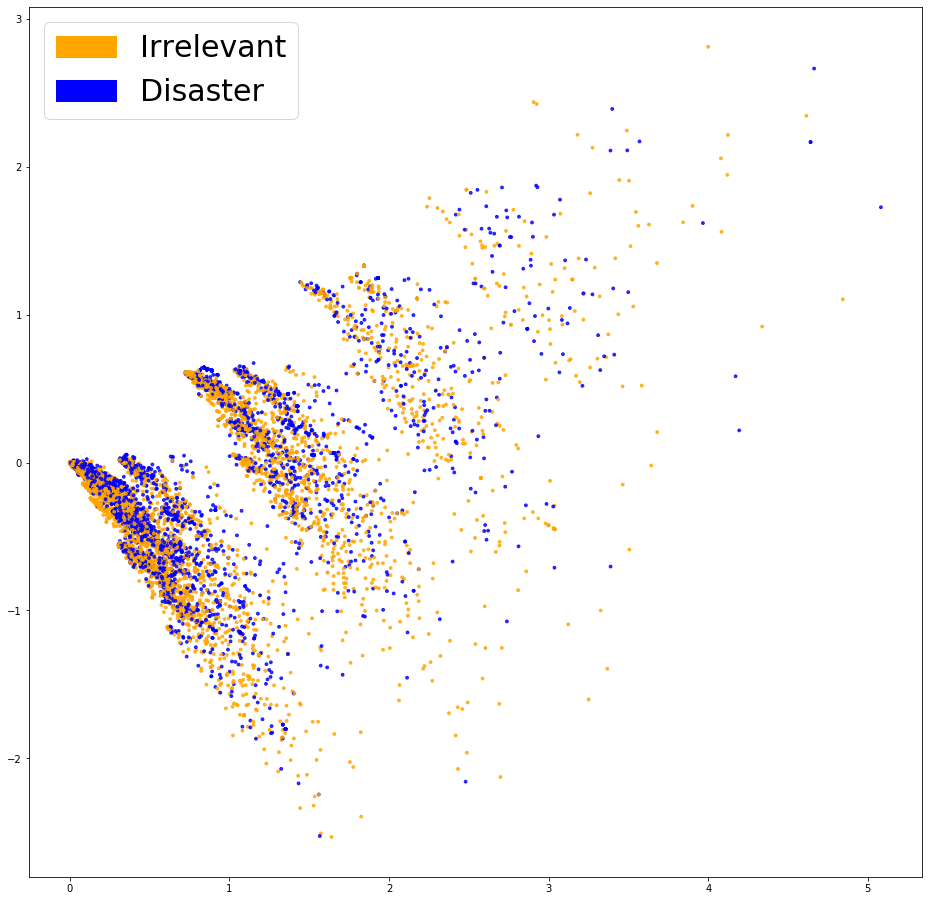

In [93]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [0]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [95]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.761, precision = 0.758, recall = 0.761, f1 = 0.759


In [0]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

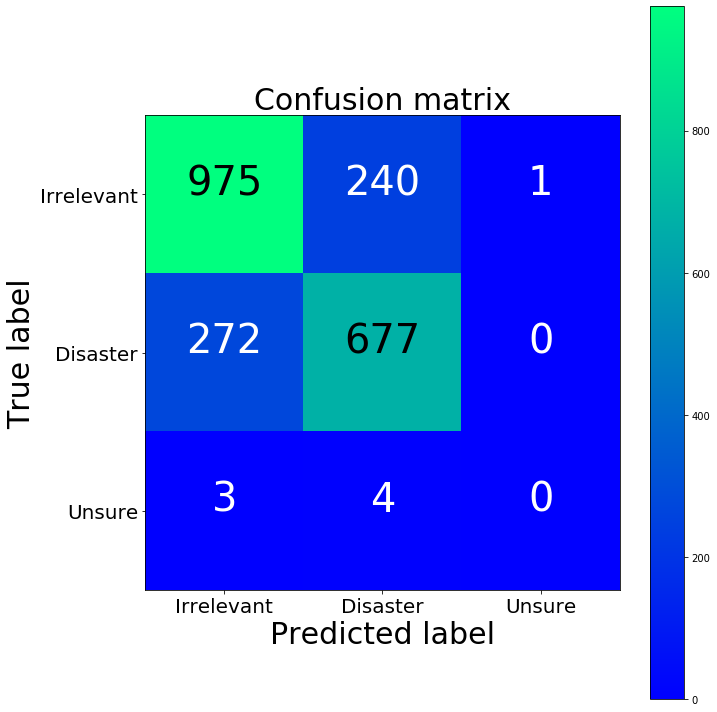

[[975 240   1]
 [272 677   0]
 [  3   4   0]]


In [97]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [0]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

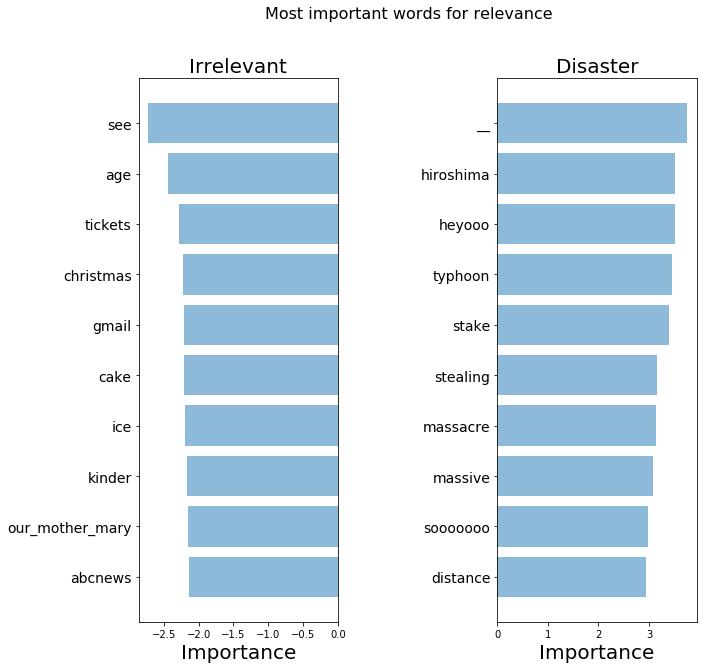

In [100]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [0]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

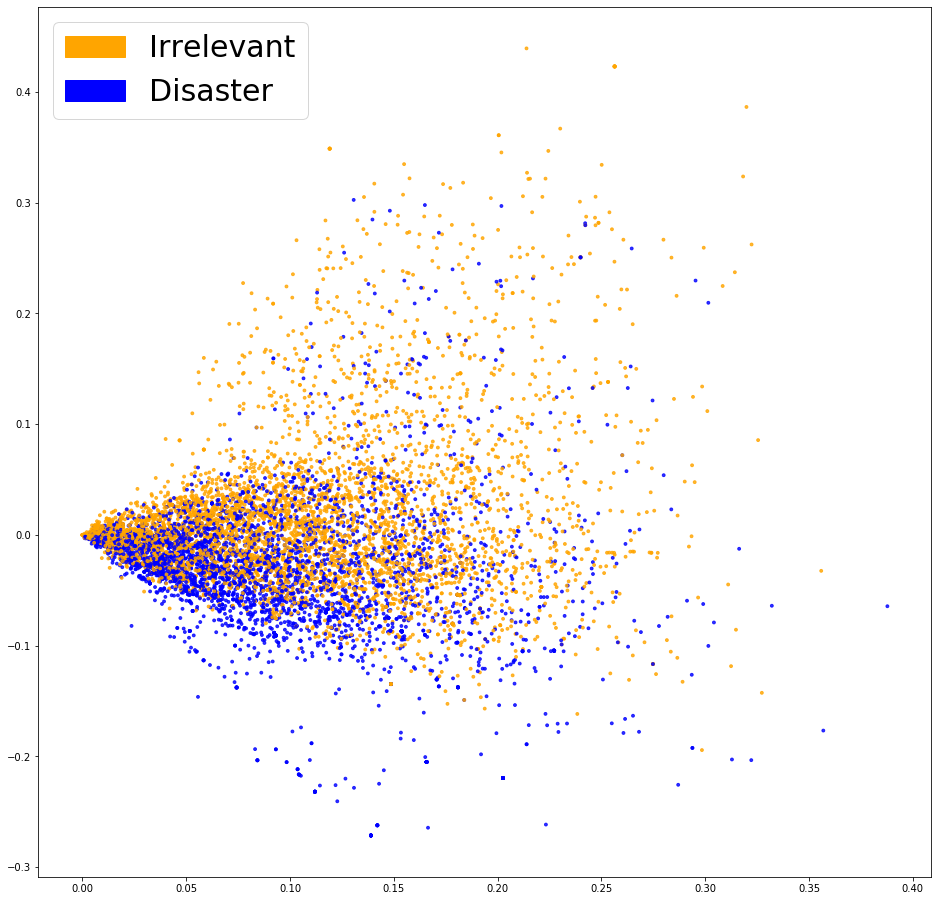

In [102]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [0]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [104]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.760, precision = 0.757, recall = 0.760, f1 = 0.758


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



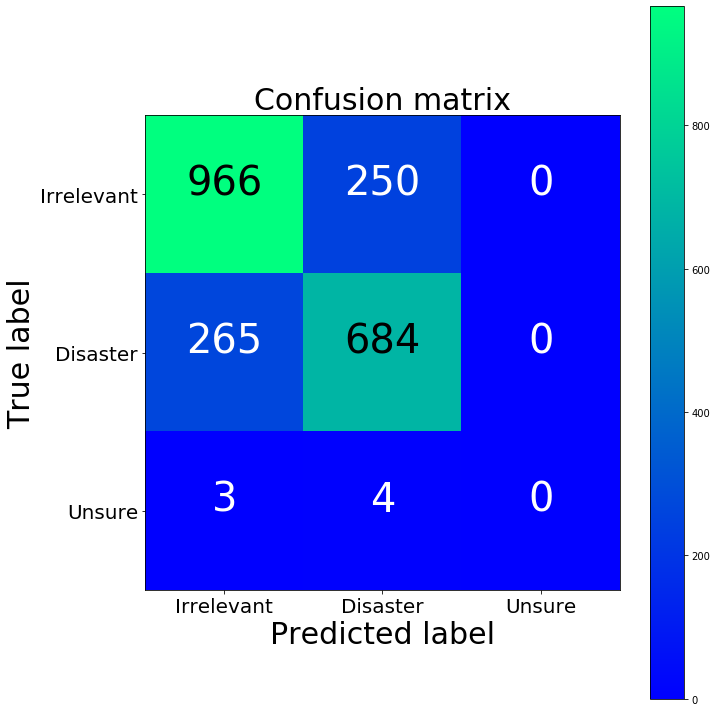

TFIDF confusion matrix
[[966 250   0]
 [265 684   0]
 [  3   4   0]]
BoW confusion matrix
[[975 240   1]
 [272 677   0]
 [  3   4   0]]


In [105]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [0]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

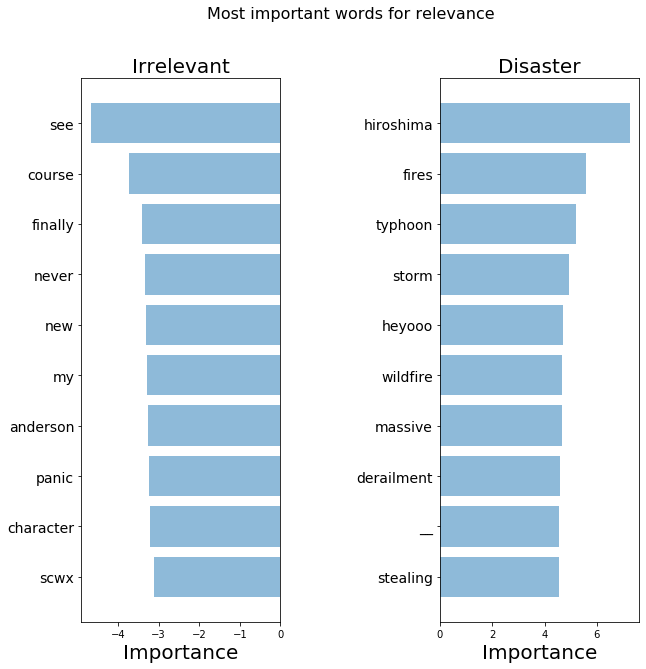

In [107]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']]
top_words = [a[1] for a in importance_tfidf[1]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [108]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from plotly import __version__
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [110]:
import gensim

word2vec_path = ('/content/drive/My Drive/Colab Notebooks/GoogleNews-vectors-negative300.bin')
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function



In [0]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [0]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

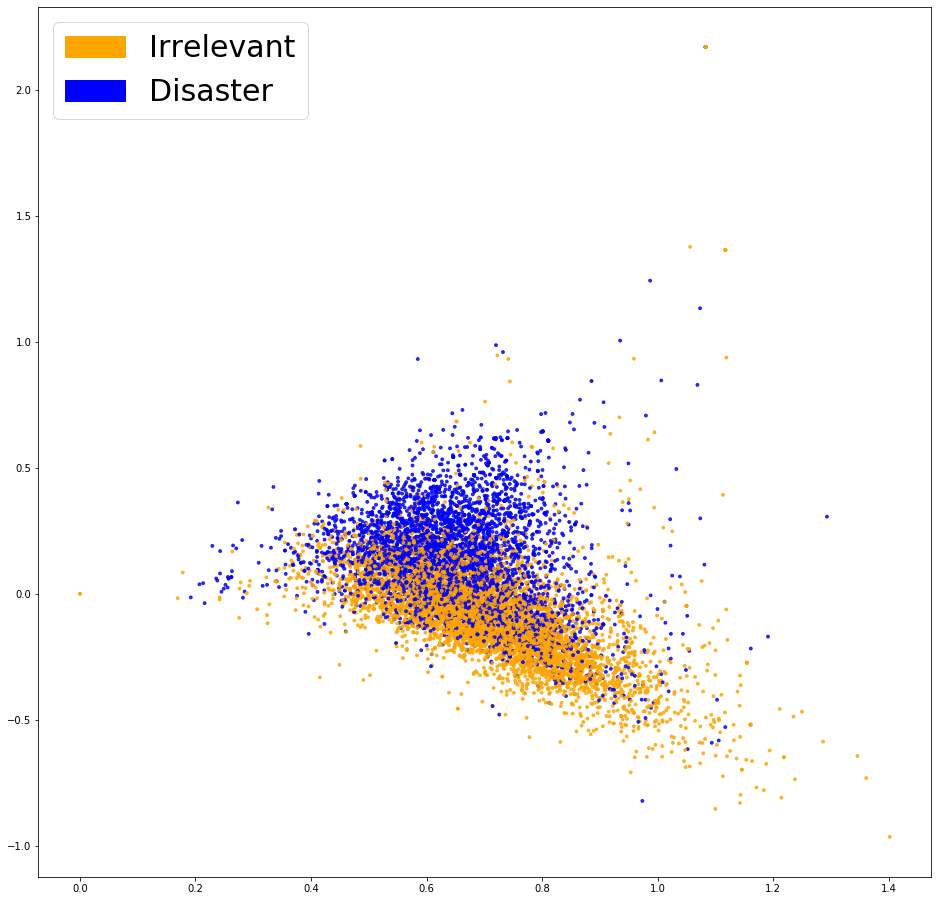

In [113]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()

In [0]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [115]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.772, precision = 0.772, recall = 0.772, f1 = 0.772


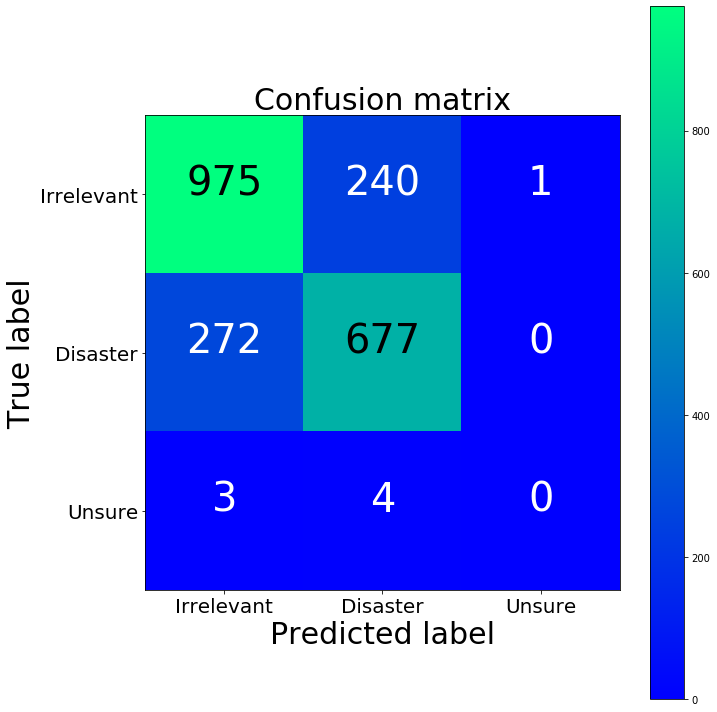

Word2Vec confusion matrix
[[982 229   5]
 [250 694   5]
 [  2   5   0]]
TFIDF confusion matrix
[[966 250   0]
 [265 684   0]
 [  3   4   0]]
BoW confusion matrix
[[975 240   1]
 [272 677   0]
 [  3   4   0]]


In [116]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [117]:
pip install lime

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for lime: filename=lime-0.1.1.37-cp36-none-any.whl size=284277 sha256=bb036320bf69ebf16343cbc618d29d534bcb8d100603a96eba29726e734df9fe
  Stored in directory: /root/.cache/pip/wheels/c1/38/e7/50d75d4fb75afa604570dc42f20c5c5f5ab26d3fbe8d6ef27b
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12073 sha256=b096385acc21b1ee2d595483e744f14e90d8a45749020678164bc8866e7e0ffb
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built lime progressbar


In [0]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [0]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["irrelevant","relevant", "unknown"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [120]:
visualize_one_exp(X_test_data, y_test_data, 65)

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:116: FutureWarning:

split() requires a non-empty pattern match.



Index: 65
True class: relevant


In [121]:
visualize_one_exp(X_test_data, y_test_data, 60)

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:116: FutureWarning:

split() requires a non-empty pattern match.



Index: 60
True class: relevant


In [122]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Irrelevant',
    1: 'Relevant',
    2: 'Unsure'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:116: FutureWarning:

split() requires a non-empty pattern match.

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:116: FutureWarning:

split() requires a non-empty pattern match.

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:116: FutureWarning:

split() requires a non-empty pattern match.

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:116: FutureWarning:

split() requires a non-empty pattern match.

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:116: FutureWarning:

split() requires a non-empty pattern match.

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:116: FutureWarning:

split() requires a non-empty pattern match.

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:116: FutureWarning:

split() requires a non-empty pattern match.

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:116: FutureWarning:

split() requires a non-empty pattern match.

/usr/local/lib/p

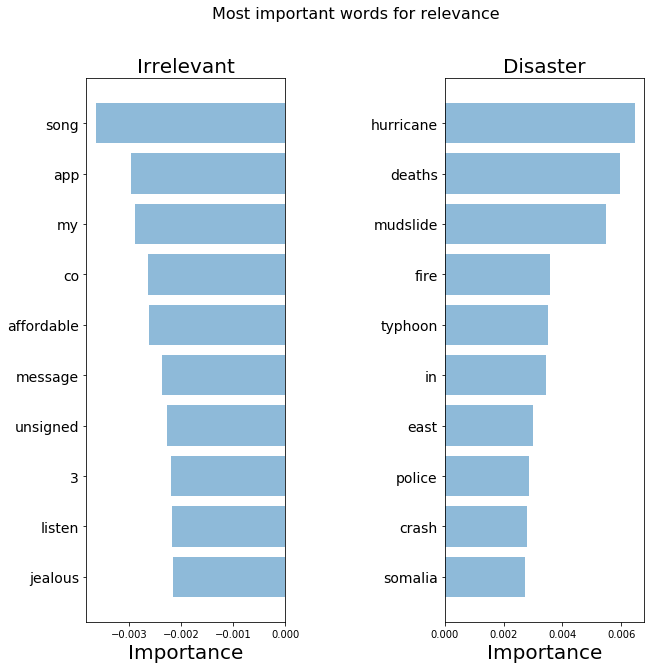

In [123]:
top_words = sorted_contributions['Relevant']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Relevant']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Relevant']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Relevant']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [124]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(clean_questions["text"].tolist())
sequences = tokenizer.texts_to_sequences(clean_questions["text"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(clean_questions["class_label"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Found 19091 unique tokens.
(19092, 300)


In [0]:
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import add
from keras.layers import concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Merge(mode='concat', concat_axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [145]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(clean_questions["class_label"].unique())), False)

NameError: ignored

In [136]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

NameError: ignored